# Import Libraries

In [87]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
from sklearn.linear_model import LogisticRegression


# Read Data and Data Description

In [66]:
data = pd.read_csv('total_data.csv')


In [67]:
data.columns

Index(['Date', 'retailer', 'Retailer Name', 'Street Addr Address',
       'Street Addr City', 'Street Addr County', 'Street Addr State',
       'Street Addr Zip', 'Business Type', 'Total Instant Sales',
       'Total Online Sales', 'Total Instant Cashes', 'Total Online Cashes',
       'P3 Sales', 'P4 Sales', 'Powerball Sales', 'PC5 Sales', 'APLY Sales',
       'Mega Millions Sales', 'LFL Sales', 'P3 Cashes', 'P4 Cashes',
       'Powerball Cashes', 'PC5 Cashes', 'APLY Cashes', 'Mega Millions Cashes',
       'LFL Cashes', 'P3 Sales Count', 'P3 Sales Cancel', 'P4 Sales Count',
       'P4 Sales Cancel', 'Powerball Sales Count', 'PC5 Sales Count',
       'APLY Sales Count', 'MegaM Sales Count', 'LFL Sales Count',
       'Instant Cashes Count', 'P3 Cashes Count', 'P4 Cashes Count',
       'Powerball Cashes Count', 'PC5 Cashes Count', 'APLY Cashes Count',
       'MegaM Cashes Count', 'LFL Cashes Count', 'fraud'],
      dtype='object')

In [68]:
data = data.drop(['Date','Retailer Name', 'Street Addr Address', 'Street Addr City',
                   'Street Addr County', 'Street Addr State','APLY Cashes Count','APLY Cashes','APLY Sales Count','APLY Sales'],
                 axis = 1)

# Convert Categorical column to Numerical

In [69]:
unique_bussines = data['Business Type'].unique()
cat_features = ['Business Type']
print(data.shape)
data = pd.get_dummies(data,columns=cat_features)
print(data.shape)

(2333437, 35)
(2333437, 45)


# Building new features

In [90]:
#Feature 1
data['Validation_Ratio'] = data['Total Instant Cashes'] / data['Instant Cashes Count'] 

In [91]:
# imputing missing valus with mean
data.Validation_Ratio.fillna(data.Validation_Ratio.mean(), inplace=True)

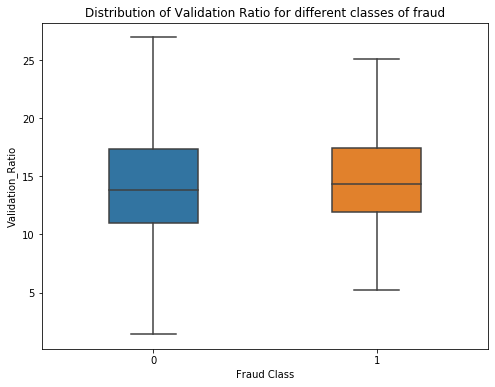

In [92]:
# Box plot to check spread of values amongst the two classes
fig = plt.figure(figsize = [8,6])
ax = sns.boxplot(x=data['fraud'], y=data['Validation_Ratio'],width=0.4,showfliers=False)
ax.set_xlabel("Fraud Class")
ax.set_ylabel("Validation_Ratio")
ax.set_title("Distribution of Validation Ratio for different classes of fraud");

In [93]:
#Feature 2
data['ValidationToSale_Ratio'] = data['Total Instant Cashes'] / data['Total Instant Sales'] 

In [94]:
#checking fraud count for infinite values, that are created because of dividing by zero[Total instant sales]
data[data['ValidationToSale_Ratio'] == np.inf]['fraud'].value_counts()

0    336019
1        32
Name: fraud, dtype: int64

In [95]:
#chaecking count of fraud for missing values
data[data['ValidationToSale_Ratio'].isna()]['fraud'].value_counts()

0    3485
Name: fraud, dtype: int64

In [96]:
#dropping all missing values because all cases are non fraud(from above cell)
data = data[-data['ValidationToSale_Ratio'].isna()]

In [97]:
#replacing infinite values with null
data = data.replace(np.inf, np.nan)

In [98]:
#imputing null values with mean
data.ValidationToSale_Ratio.fillna(data.ValidationToSale_Ratio.mean(), inplace=True)

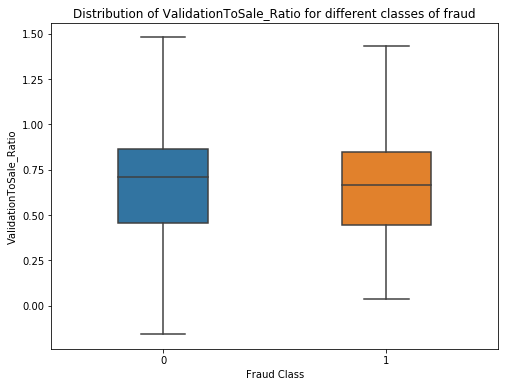

In [100]:
# Box plot to check spread of values amongst the two classes
fig = plt.figure(figsize = [8,6])
ax = sns.boxplot(x=data['fraud'], y=data['ValidationToSale_Ratio'],width=0.4,showfliers=False)
ax.set_xlabel("Fraud Class")
ax.set_ylabel("ValidationToSale_Ratio")
ax.set_title("Distribution of ValidationToSale_Ratio for different classes of fraud");

# split up test, train

In [84]:
y = data['fraud']
x = data.drop('fraud', axis = 1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.20)

xtrain = xtrain.copy()
xtest = xtest.copy()
ytrain = ytrain.copy()
ytest = ytest.copy()

In [71]:
print(ytrain.value_counts())
print(ytest.value_counts())

0    1866411
1        338
Name: fraud, dtype: int64
0    466605
1        83
Name: fraud, dtype: int64


# Random Undersampling for MLP Classifier

In [85]:

from imblearn.under_sampling import (RandomUnderSampler)

# RandomUnderSampler
sampler = RandomUnderSampler(0.001,random_state=11)
x_train, y_train = sampler.fit_resample(xtrain, ytrain)
print('Random undersampling {}'.format(Counter(y_train)))

Random undersampling Counter({0: 351000, 1: 351})


In [88]:
# MLP

MLPClassifier = MLPClassifier()
#fit data
MLPClassifier.fit(x_train, y_train) 

#predict test
train_predicted = MLPClassifier.predict(x_train)
test_predicted = MLPClassifier.predict(xtest)

#Train Accuracy
print("Train Results:")
print(accuracy_score(y_train, train_predicted))
print(confusion_matrix(y_train, train_predicted))
print(classification_report(y_train, train_predicted))

#Test Accuracy
print()
print("Test Results:")
print(accuracy_score(ytest, test_predicted))
print(confusion_matrix(ytest, test_predicted))
print(classification_report(ytest, test_predicted))


Train Results:
0.999000999000999
[[351000      0]
 [   351      0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    351000
           1       0.00      0.00      0.00       351

    accuracy                           1.00    351351
   macro avg       0.50      0.50      0.50    351351
weighted avg       1.00      1.00      1.00    351351


Test Results:
0.9998500068568295
[[466618      0]
 [    70      0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    466618
           1       0.00      0.00      0.00        70

    accuracy                           1.00    466688
   macro avg       0.50      0.50      0.50    466688
weighted avg       1.00      1.00      1.00    466688



In [89]:
test_actual_predicted = pd.DataFrame({'Actual':ytest,'Predicted':MLPClassifier.predict(xtest),'Predicted_prob_class1':MLPClassifier.predict_proba(xtest)[:,1]})

In [75]:
#Threshold Analysis for class 'fraud'

actual_1 = (test_actual_predicted.Actual == 1).sum()
i=0
frame = []
while i<=0.9:
    req = test_actual_predicted[test_actual_predicted['Predicted_prob_class1']>=i]
    actualfraud =  (req.Actual ==1).sum() 
    recall = (req.Actual ==1).sum() / actual_1
    precision = (req.Actual ==1).sum() / len(req)
    ls = i,len(req),actualfraud,precision,recall
    frame.append(list(ls))
    i+=0.1
resultFn = pd.DataFrame(frame,columns=['Threshold','TotalRecords','ActualFraudCaptured','Precision','Recall'])
resultFn

,Threshold,TotalRecords,ActualFraudCaptured,Precision,Recall
0,0.0,466688,83,0.000178,1.0
1,0.1,0,0,NaN,0.0
2,0.2,0,0,NaN,0.0
3,0.3,0,0,NaN,0.0
4,0.4,0,0,NaN,0.0
5,0.5,0,0,NaN,0.0
6,0.6,0,0,NaN,0.0
7,0.7,0,0,NaN,0.0
8,0.8,0,0,NaN,0.0
9,0.9,0,0,NaN,0.0


# Random Undersampling for more models(different ratio)

In [104]:

from imblearn.under_sampling import (RandomUnderSampler)

# RandomUnderSampler
sampler = RandomUnderSampler(0.02,random_state=11)
xtrain, ytrain = sampler.fit_resample(xtrain, ytrain)
print('Random undersampling {}'.format(Counter(ytrain)))

Random undersampling Counter({0: 17550, 1: 351})


# Logistic 

In [77]:
LRClassifier = LogisticRegression(random_state=11, solver='lbfgs', C=10, max_iter=5000)
#fit data
LRClassifier.fit(xtrain, ytrain)

#predict test
train_predicted = LRClassifier.predict(xtrain)
test_predicted = LRClassifier.predict(xtest)

#Train Accuracy
print("Train Results:")
print(accuracy_score(ytrain, train_predicted))
print(confusion_matrix(ytrain, train_predicted))
print(classification_report(ytrain, train_predicted))

#Test Accuracy
print()
print("Test Results:")
print(accuracy_score(ytest, test_predicted))
print(confusion_matrix(ytest, test_predicted))
print(classification_report(ytest, test_predicted))


Train Results:
0.9803921568627451
[[16898     2]
 [  336     2]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16900
           1       0.50      0.01      0.01       338

    accuracy                           0.98     17238
   macro avg       0.74      0.50      0.50     17238
weighted avg       0.97      0.98      0.97     17238


Test Results:
0.999730012342293
[[466562     43]
 [    83      0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    466605
           1       0.00      0.00      0.00        83

    accuracy                           1.00    466688
   macro avg       0.50      0.50      0.50    466688
weighted avg       1.00      1.00      1.00    466688



In [78]:
test_actual_predicted = pd.DataFrame({'Actual':ytest,'Predicted':LRClassifier.predict(xtest),'Predicted_prob_class1':LRClassifier.predict_proba(xtest)[:,1]})

In [79]:
#Threshold Analysis for class 'fraud'

actual_1 = (test_actual_predicted.Actual == 1).sum()
i=0
frame = []
while i<=0.9:
    req = test_actual_predicted[test_actual_predicted['Predicted_prob_class1']>=i]
    actualfraud =  (req.Actual ==1).sum() 
    recall = (req.Actual ==1).sum() / actual_1
    precision = (req.Actual ==1).sum() / len(req)
    ls = i,len(req),actualfraud,precision,recall
    frame.append(list(ls))
    i+=0.1
resultFn = pd.DataFrame(frame,columns=['Threshold','TotalRecords','ActualFraudCaptured','Precision','Recall'])
resultFn

,Threshold,TotalRecords,ActualFraudCaptured,Precision,Recall
0,0.0,466688,83,0.000178,1.000000
1,0.1,731,1,0.001368,0.012048
2,0.2,216,0,0.000000,0.000000
3,0.3,113,0,0.000000,0.000000
4,0.4,69,0,0.000000,0.000000
5,0.5,43,0,0.000000,0.000000
6,0.6,27,0,0.000000,0.000000
7,0.7,20,0,0.000000,0.000000
8,0.8,15,0,0.000000,0.000000
9,0.9,12,0,0.000000,0.000000


# Gradient Boosting Classifier

In [80]:

GBClassifier = GradientBoostingClassifier(n_estimators=500,learning_rate=0.01,random_state=11)
#fit data
GBClassifier.fit(xtrain, ytrain) 

#predict test
train_predicted = GBClassifier.predict(xtrain)
test_predicted = GBClassifier.predict(xtest)

#Train Accuracy
print("Train Results:")
print(accuracy_score(ytrain, train_predicted))
print(confusion_matrix(ytrain, train_predicted))
print(classification_report(ytrain, train_predicted))

#Test Accuracy
print()
print("Test Results:")
print(accuracy_score(ytest, test_predicted))
print(confusion_matrix(ytest, test_predicted))
print(classification_report(ytest, test_predicted))


Train Results:
0.9835247708550876
[[16899     1]
 [  283    55]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16900
           1       0.98      0.16      0.28       338

    accuracy                           0.98     17238
   macro avg       0.98      0.58      0.64     17238
weighted avg       0.98      0.98      0.98     17238


Test Results:
0.9996828716401536
[[466531     74]
 [    74      9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    466605
           1       0.11      0.11      0.11        83

    accuracy                           1.00    466688
   macro avg       0.55      0.55      0.55    466688
weighted avg       1.00      1.00      1.00    466688



In [81]:
test_actual_predicted = pd.DataFrame({'Actual':ytest,'Predicted':GBClassifier.predict(xtest),'Predicted_prob_class1':GBClassifier.predict_proba(xtest)[:,1]})

In [82]:
#Threshold Analysis for class 'fraud'

actual_1 = (test_actual_predicted.Actual == 1).sum()
i=0
frame = []
while i<=0.9:
    req = test_actual_predicted[test_actual_predicted['Predicted_prob_class1']>=i]
    actualfraud =  (req.Actual ==1).sum() 
    recall = (req.Actual ==1).sum() / actual_1
    precision = (req.Actual ==1).sum() / len(req)
    ls = i,len(req),actualfraud,precision,recall
    frame.append(list(ls))
    i+=0.1
resultFn = pd.DataFrame(frame,columns=['Threshold','TotalRecords','ActualFraudCaptured','Precision','Recall'])
resultFn

,Threshold,TotalRecords,ActualFraudCaptured,Precision,Recall
0,0.0,466688,83,0.000178,1.000000
1,0.1,2094,41,0.019580,0.493976
2,0.2,605,37,0.061157,0.445783
3,0.3,419,31,0.073986,0.373494
4,0.4,242,22,0.090909,0.265060
5,0.5,83,9,0.108434,0.108434
6,0.6,28,3,0.107143,0.036145
7,0.7,11,0,0.000000,0.000000
8,0.8,4,0,0.000000,0.000000
9,0.9,0,0,NaN,0.000000


# Support Vector Machine (SVM)

In [107]:
from sklearn.svm import SVC
SVClassifier = SVC(C=10, kernel='linear', random_state=11,probability=True)
#fit data
SVClassifier.fit(xtrain, ytrain)

#predict test
train_predicted = SVClassifier.predict(xtrain)
test_predicted = SVClassifier.predict(xtest)

#Train Accuracy
print("Train Results:")
print(accuracy_score(ytrain, train_predicted))
print(confusion_matrix(ytrain, train_predicted))
print(classification_report(ytrain, train_predicted))

#Test Accuracy
print()
print("Test Results:")
print(accuracy_score(ytest, test_predicted))
print(confusion_matrix(ytest, test_predicted))
print(classification_report(ytest, test_predicted))


Train Results:
0.9803362940617842
[[17549     1]
 [  351     0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17550
           1       0.00      0.00      0.00       351

    accuracy                           0.98     17901
   macro avg       0.49      0.50      0.50     17901
weighted avg       0.96      0.98      0.97     17901


Test Results:
0.9997835813219967
[[466587     31]
 [    70      0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    466618
           1       0.00      0.00      0.00        70

    accuracy                           1.00    466688
   macro avg       0.50      0.50      0.50    466688
weighted avg       1.00      1.00      1.00    466688



In [ ]:
test_actual_predicted = pd.DataFrame({'Actual':ytest,'Predicted':SVClassifier.predict(xtest),'Predicted_prob_class1':SVClassifier.predict_proba(xtest)[:,1]})